In [224]:
import pandas as pd
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [185]:
# using 1000 of each positive and negative reviews
df = pd.read_csv(r"IMDB Dataset.csv")
df_positive= df[df['sentiment'] == 'positive'].head(1000)
df_negative= df[df['sentiment'] == 'negative'].head(1000)
df = pd.concat([df_positive, df_negative])
# print(df.info())

In [186]:
#Variables for data cleaning

# regular expression to remove characters that are not letters or spaces
regex = re.compile('[^a-zA-Z ]')

# stopwords
stopwords = stopwords.words('english')
stopwords_no_punct = [regex.sub('', word) for word in stopwords]
stopwords_no_punct.append("br")
stopwords_new = set(stopwords + stopwords_no_punct)

In [187]:
# Data cleaning

df['review_cleaned'] = df['review'].astype("string").apply(lambda x: regex.sub('', x))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: " ".join(x.split()))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: word_tokenize(x.lower()))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: [word for word in x if word not in stopwords_new])

print(df.head(10))

                                               review sentiment  \
0   One of the other reviewers has mentioned that ...  positive   
1   A wonderful little production. <br /><br />The...  positive   
2   I thought this was a wonderful way to spend ti...  positive   
4   Petter Mattei's "Love in the Time of Money" is...  positive   
5   Probably my all-time favorite movie, a story o...  positive   
6   I sure would like to see a resurrection of a u...  positive   
9   If you like original gut wrenching laughter yo...  positive   
14  This a fantastic movie of three prisoners who ...  positive   
16  Some films just simply should not be remade. T...  positive   
18  I remember this film,it was the first film i h...  positive   

                                       review_cleaned  
0   [one, reviewers, mentioned, watching, oz, epis...  
1   [wonderful, little, production, filming, techn...  
2   [thought, wonderful, way, spend, time, hot, su...  
4   [petter, matteis, love, time, mone

In [188]:
# POS taging

df['tagged'] = df['review_cleaned'].apply(lambda x: nltk.pos_tag(x))

In [189]:
# df_sus = df[df['tagged'].apply(lambda row: any(tag == "''" for (_, tag) in row))]
# print(df_sus)

In [190]:
# print(df['tagged'][2007])

In [191]:
# POS count
pos_count_by_type = {}

for group_value, group_df in df.groupby("sentiment"):
    tags = [tag for row in group_df["tagged"] for (_, tag) in row]
    pos_count_by_type[group_value] = Counter(tags)

print(pos_count_by_type)

{'negative': Counter({'NN': 37120, 'JJ': 22113, 'NNS': 11441, 'RB': 9673, 'VBP': 5710, 'VBG': 5147, 'VBD': 4613, 'VBN': 2963, 'VBZ': 2811, 'VB': 2750, 'IN': 2461, 'CD': 1431, 'MD': 1246, 'JJS': 578, 'JJR': 410, 'DT': 359, 'RBR': 358, 'PRP': 161, 'FW': 136, 'CC': 128, 'RP': 89, 'NNP': 69, 'WDT': 51, 'WP$': 29, 'RBS': 23, 'WRB': 22, 'TO': 16, 'UH': 15, 'WP': 14, 'PRP$': 2, 'EX': 1, 'SYM': 1, 'NNPS': 1, "''": 1}), 'positive': Counter({'NN': 39512, 'JJ': 23829, 'NNS': 12406, 'RB': 9390, 'VBP': 6065, 'VBG': 4951, 'VBD': 4471, 'VBZ': 3359, 'VBN': 2898, 'VB': 2719, 'IN': 2433, 'CD': 1526, 'MD': 1086, 'JJS': 606, 'JJR': 387, 'DT': 350, 'RBR': 273, 'PRP': 187, 'FW': 140, 'RP': 114, 'CC': 95, 'NNP': 75, 'RBS': 52, 'WP$': 41, 'WDT': 18, 'WRB': 18, 'UH': 13, 'WP': 10, 'PRP$': 4, 'TO': 3})}


In [241]:
# POS dataframe
pos_df = pd.DataFrame(pos_count_by_type).reset_index()
pos_df.rename(columns={'index':'pos'}, inplace=True)

# top 10 positive POS
pos_positive = pos_df[['pos', 'positive']].sort_values(by='positive', ascending=False).head(10)
pos_positive = pos_positive.sort_values(by='positive') # just for plotting

# top 10 negative POS
pos_negative = pos_df[['pos', 'negative']].sort_values(by='negative', ascending=False).head(10)
pos_negative = pos_negative.sort_values(by='negative') # just for plotting

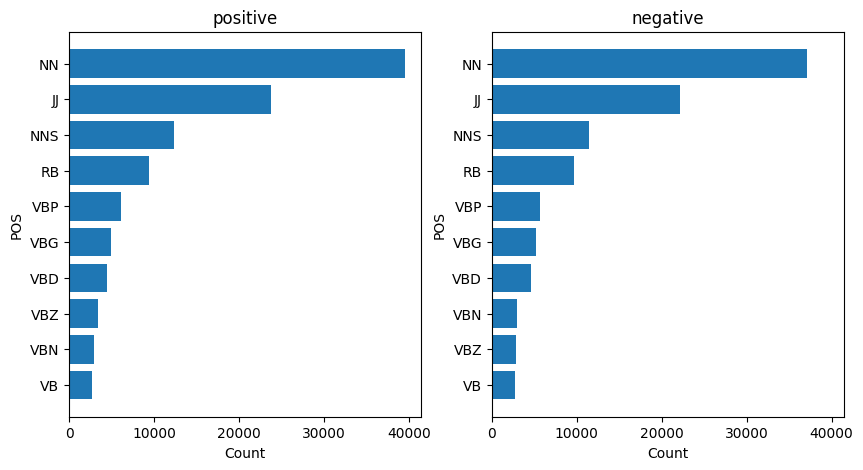

In [244]:
# POS visualization

fig_pos, ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

ax[0].barh(pos_positive['pos'], pos_positive['positive'])
ax[0].set_xlabel('Count')
ax[0].set_ylabel('POS')
ax[0].set_title('positive')

ax[1].barh(pos_negative['pos'], pos_negative['negative'])
ax[1].set_xlabel('Count')
ax[1].set_ylabel('POS')
ax[1].set_title('negative')

plt.show()

# fig_pos.savefig('pos_chart.png')

In [215]:
# Lemmatization
nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['review_cleaned'].apply(lambda x: [word.lemma_ for word in nlp(' '.join(x))])
print(df.head())

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
4  Petter Mattei's "Love in the Time of Money" is...  positive   
5  Probably my all-time favorite movie, a story o...  positive   

                                      review_cleaned  \
0  [one, reviewers, mentioned, watching, oz, epis...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
4  [petter, matteis, love, time, money, visually,...   
5  [probably, alltime, favorite, movie, story, se...   

                                              tagged  \
0  [(one, CD), (reviewers, NNS), (mentioned, VBD)...   
1  [(wonderful, JJ), (little, JJ), (production, N...   
2  [(thought, VBN), (wonderful, JJ), (way, NN), (...   
4  [(petter, NN), (matteis, RBS), (love, J

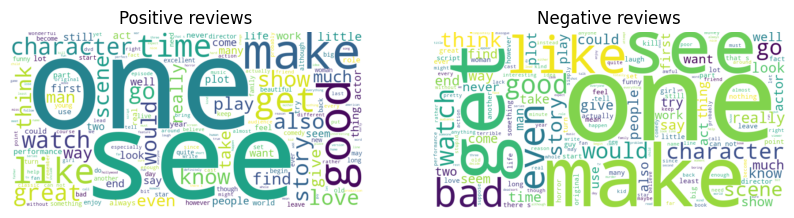

In [247]:
# wordcloud

exclude_words = ['film', 'movie']

positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

positive_text = [word for row in positive_df['lemmatized'] for word in row]
positive_text = " ".join(positive_text)

negative_text = [word for row in negative_df['lemmatized'] for word in row]
negative_text = " ".join(negative_text)

wordcloud_positive = WordCloud(width=800,
                               height=400,
                               background_color='white',
                               stopwords=exclude_words).generate(positive_text)
wordcloud_negative = WordCloud(width=800,
                               height=400,
                               background_color='white',
                               stopwords=exclude_words).generate(negative_text)

plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Positive reviews")

plt.subplot(1,2,2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Negative reviews")

plt.show()

In [222]:
# creating corpus

corpus = df['lemmatized'].apply(" ".join).to_list()
# print(corpus)

# encoding sentiment as 0/1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])
# print(Y)

# vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus)


In [229]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

# logistic regression

model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 score: {f1:}")


Accuracy: 0.7725
Precision: 0.7767926454279666
Recall: 0.7725
F1 score: 0.7720744098453991


In [231]:
# SVM
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("accuracy:", accuracy_svm)


accuracy: 0.7475
